In [85]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import kagglehub

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

Load Datasets

In [86]:
dataset_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

paths = []
labels = []

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [87]:
len(paths)

2800

In [88]:
paths[:5]

['/home/jom/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_sell_disgust.wav',
 '/home/jom/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_page_disgust.wav',
 '/home/jom/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_juice_disgust.wav',
 '/home/jom/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_dab_disgust.wav',
 '/home/jom/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_mode

In [89]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [90]:
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()

,audio_paths,labels
0,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,disgust
1,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,disgust
2,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,disgust
3,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,disgust
4,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,disgust


In [91]:
df['labels'].value_counts()

labels
disgust    400
angry      400
sad        400
happy      400
ps         400
fear       400
neutral    400
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

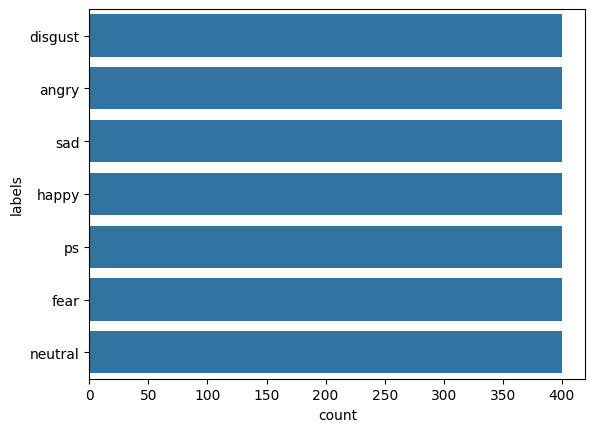

In [92]:

sns.countplot(df['labels'])

In [93]:

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

In [94]:
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [95]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels
0,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,0
1,/home/jom/.cache/kagglehub/datasets/ejlok1/tor...,0


In [96]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)
    

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        #load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)
        # speech, sr = torchaudio.load(audio_path)
        # speech = torchaudio.functional.resample(speech, sr, 16000)
        # speech = speech.squeeze().numpy()

        #pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant') 

        #preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [97]:
#Split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [98]:
#Initialize hte processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
#load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [100]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [101]:
#Create Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Set Training Arguments

In [102]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [103]:
# Create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids #True labels
    preds = np.argmax(pred.predictions, axis=1) #Model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1 
    }

In [104]:
#Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.645456,0.998214,0.998237,0.998214,0.998215
2,No log,0.237426,0.996429,0.996519,0.996429,0.996432
3,No log,0.166364,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.6796680268787202, metrics={'train_runtime': 171.7867, 'train_samples_per_second': 39.118, 'train_steps_per_second': 2.445, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6796680268787202, 'epoch': 3.0})

In [105]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.16636444628238678, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.4246, 'eval_samples_per_second': 163.523, 'eval_steps_per_second': 10.22, 'epoch': 3.0}


## Test Predictions

In [177]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[test_dataset[idx]['labels'].item()])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: sad
Predicted Label: sad


In [ ]:
# Save the trained model and processor
model.save_pretrained('./trained_model')
processor.save_pretrained('./trained_model')
